4-(1) 문제

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
'''
np.random.seed(seed=1)
N = 1000 #데이터 수
K = 3 #분포 수
T3 = np.zeros((N,3),dtype=np.uint8) # (n , 3) 차원
T2 = np.zeros((N,2),dtype=np.uint8) # (n , 2) 차원
X = np.zeros((N,2))

Mu = np.array([[-2.0,-2.0],[1.5,2.0],[2,-1.5]]) #분포의 중심
Sig = np.array([[.9,.9],[.8,.7],[.9,1.0]]) #분포의 분산
Pi = np.array([0.35,0.7,1.0]) #각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk<Pi[k]:
            T3[n,k]=1
            break
    for k in range(2):
        X[n,k] = (np.random.randn()*Sig[T3[n,:]==1,k]+Mu[T3[n,:]==1,k])
    T2[:,0] = T3[:,0]
    T2[:,1] = T3[:,1]|T3[:,2]
'''

'\nnp.random.seed(seed=1)\nN = 1000 #데이터 수\nK = 3 #분포 수\nT3 = np.zeros((N,3),dtype=np.uint8) # (n , 3) 차원\nT2 = np.zeros((N,2),dtype=np.uint8) # (n , 2) 차원\nX = np.zeros((N,2))\n\nMu = np.array([[-2.0,-2.0],[1.5,2.0],[2,-1.5]]) #분포의 중심\nSig = np.array([[.9,.9],[.8,.7],[.9,1.0]]) #분포의 분산\nPi = np.array([0.35,0.7,1.0]) #각 분포에 대한 비율\nfor n in range(N):\n    wk = np.random.rand()\n    for k in range(K):\n        if wk<Pi[k]:\n            T3[n,k]=1\n            break\n    for k in range(2):\n        X[n,k] = (np.random.randn()*Sig[T3[n,:]==1,k]+Mu[T3[n,:]==1,k])\n    T2[:,0] = T3[:,0]\n    T2[:,1] = T3[:,1]|T3[:,2]\n'

In [39]:
np.random.seed(seed=1) # 난수를 고정
N = 1000 # 데이터의 수
K = 3 # 분포의 수
Y = np.zeros((N, 3), dtype=np.uint8) # 분류목적으로 target은 One-hot encoding 방식으로 표현 1->[1,0], 2->[0,1]
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-2.0,-2.0],[1.5,2.0],[2,-1.5]]) #분포의 중심
Sig = np.array([[.9,.9],[.8,.7],[.9,1.0]]) #분포의 표준편차
Pi = np.array([0.35,0.7,1.0]) #각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            Y[n, k] = 1 # Pi 비율을 참조하여 target 값 결정
            break
    # 가우시안 샘플링
    for k in range(2): 
        X[n, k] = np.random.randn() * Sig[Y[n, :] == 1, k] + Mu[Y[n, :] == 1, k] # 랜덤값 * 분산 + 평균값(이동)


# -------- 2 Training 데이터셋, validation 데이터셋, test 데이터셋으로 분할
#YestRatio = 0.6
#X_n_training = int(N * YestRatio)
X_train = X[:600] # 600
X_valid = X[600:800] # 200
X_test = X[800:] # 200
Y_train = Y[:600] # 600
Y_valid = Y[600:800] # 200
Y_test = Y[800:] # 200

In [40]:
#데이터 표시
def show_data(x,t):
    wk, K = t.shape
    c = [[.5,.5,.5], [1,1,1], [0,0,0]]
    for k in range(K):
        plt.plot(x[t[:,k] ==1,0],x[t[:,k]==1,1],
                linestyle='none',markeredgecolor='black',
                marker='o',color=c[k],alpha=.8)
        plt.grid(True)

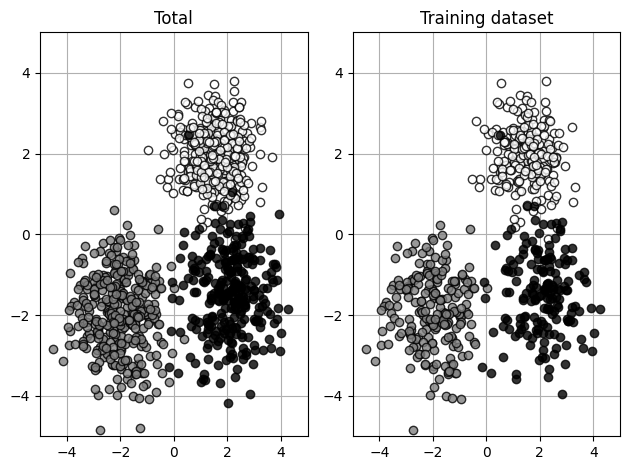

In [41]:
#X0 표시 범위
X_range0 = [-5,5]
#X1 표시 범위
X_range1 = [-5,5]

plt.subplot(1,2,1)
show_data(X,Y)
plt.title('Total')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1,2,2)
show_data(X_train,Y_train)
plt.title('Training dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.tight_layout()
plt.show()

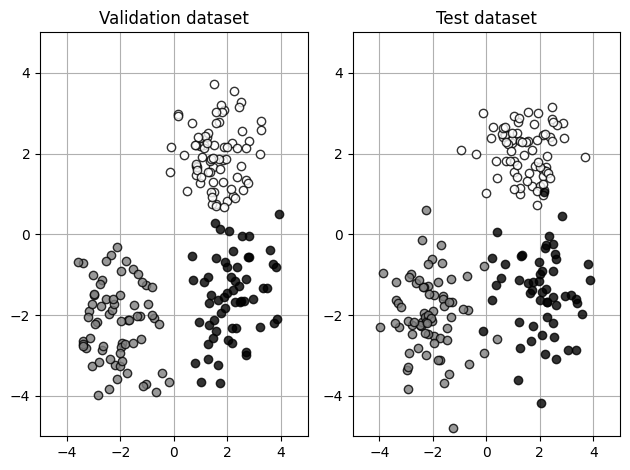

In [42]:
plt.subplot(1,2,1)
show_data(X_valid,Y_valid)
plt.title('Validation dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1,2,2)
show_data(X_test,Y_test)
plt.title('Test dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.tight_layout()
plt.show()